In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import ptitprince as pt
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

from dotenv import load_dotenv
import os
import glob
import json
from models.session import Session

In [2]:
# directory management
pilot_name = "rn-iii-pilot-5"
to_save_plots = False
data_path = f"../../data/for_plots/{pilot_name}"

figures_path = f"../figures/ic2s2"
if not os.path.exists(figures_path):
    os.makedirs(figures_path)

scores_df = pd.read_csv(os.path.join(data_path,"scores.csv"),index_col=0)
trials_time = pd.read_csv(os.path.join(data_path,"trials_time.csv"))
sessions_time = pd.read_csv(os.path.join(data_path,"sessions_time.csv"))
post_survey_df = pd.read_csv(os.path.join(data_path,"post_survey_df.csv"),index_col=0)

# preprocess score data

In [3]:
scores_df.replace({"isAI": {True: 'AI', False: 'Human'}}, inplace=True)
scores_df.groupby(by=["expName","trialType","isAI"]).size()

expName          trialType      isAI 
rn-iii-pilot-5a  demonstration  Human     10
                 individual     Human    140
                 try_yourself   Human     10
rn-iii-pilot-5b  demonstration  AI        40
                                Human     11
                 individual     AI        40
                                Human     66
                 try_yourself   AI        10
                                Human     88
rn-iii-pilot-5c  demonstration  AI        40
                                Human     10
                 individual     AI        40
                                Human     60
                 try_yourself   AI        10
                                Human     80
dtype: int64

In [4]:
# remove session in 5B that was recorded twice by mistake!!
scores_df = scores_df[~scores_df['sessionId'].isin(["647731a58664fd383a5bfc1a"])]
scores_df.groupby(by=["expName","trialType","isAI"]).size()

expName          trialType      isAI 
rn-iii-pilot-5a  demonstration  Human     10
                 individual     Human    140
                 try_yourself   Human     10
rn-iii-pilot-5b  demonstration  AI        40
                                Human     10
                 individual     AI        40
                                Human     60
                 try_yourself   AI        10
                                Human     80
rn-iii-pilot-5c  demonstration  AI        40
                                Human     10
                 individual     AI        40
                                Human     60
                 try_yourself   AI        10
                                Human     80
dtype: int64

In [5]:
# make plot hue
scores_dfA_human = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName']=='rn-iii-pilot-5a') & (scores_df['trialType']=='individual')]

scores_dfB_ai = scores_df[(scores_df['isAI']=='AI') & (scores_df['expName']=='rn-iii-pilot-5b')]
scores_dfB_human = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName']=='rn-iii-pilot-5b')]

scores_dfC_ai = scores_df[(scores_df['isAI']=='AI') & (scores_df['expName']=='rn-iii-pilot-5c')]
scores_dfC_human = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName']=='rn-iii-pilot-5c')]

scores_dfB_human.loc[scores_dfB_human['trialIdx'].isin([10,13,16,19]), 'trialType'] = 'try_yourself_before'
scores_dfB_human.loc[scores_dfB_human['trialIdx'].isin([12,15,18,21]), 'trialType'] = 'try_yourself_after'
scores_dfB_human.loc[scores_dfB_human['trialIdx'].isin([4,5]), 'trialType'] = 'individual_before'
scores_dfB_human.loc[scores_dfB_human['trialIdx'].isin([23,24,25,26]), 'trialType'] = 'individual_after'

scores_dfC_human.loc[scores_dfC_human['trialIdx'].isin([10,13,16,19]), 'trialType'] = 'try_yourself_before'
scores_dfC_human.loc[scores_dfC_human['trialIdx'].isin([12,15,18,21]), 'trialType'] = 'try_yourself_after'
scores_dfC_human.loc[scores_dfC_human['trialIdx'].isin([4,5]), 'trialType'] = 'individual_before'
scores_dfC_human.loc[scores_dfC_human['trialIdx'].isin([23,24,25,26]), 'trialType'] = 'individual_after'

### fix missing move penalty in 5B

In [6]:
moves = pd.read_csv(os.path.join(f"../../data/final/rn-iii-pilot-5b/moves.csv"),sep=',', index_col=0)
trial = pd.read_csv(os.path.join(f"../../data/final/rn-iii-pilot-5b/trial.csv"),sep=',', index_col=0)


human_session_ids = list(scores_df[(scores_df['isAI']=='Human') & (scores_df['expName']=='rn-iii-pilot-5b')]['sessionId'].unique())
moves_human = moves[moves['sessionId'].isin(human_session_ids)]
missings = moves_human.groupby(by=['sessionId','trialID']).agg(n_missings=('isMissing','sum')).reset_index()

print(f"{len(missings[missings['n_missings']>0])} out of {len(missings)} trials "
      f"({round(len(missings[missings['n_missings']>0]) / len(missings) *100,2)} %) have missing steps")

22 out of 140 trials (15.71 %) have missing steps


In [7]:
scoreB_updated = moves_human.groupby(by=['sessionId','trialID']).agg(score_true=("reward",'sum'),
                                                                     n_missings=('isMissing','sum')).reset_index()

scores_dfB_human_merged = pd.merge(scores_dfB_human,scoreB_updated,how='inner',left_on=['sessionId','trialIdx'],right_on=['sessionId','trialID'])
scores_dfB_human_merged

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,trialID,score_true,n_missings
0,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,10.0,try_yourself_before,949d93f06b9a159e993467fe9d6eec5a,400.0,1.0,500.0,1150.0,10,400,0
1,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,12.0,try_yourself_after,949d93f06b9a159e993467fe9d6eec5a,950.0,4.0,500.0,1150.0,12,950,0
2,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,13.0,try_yourself_before,13cca31d179666d20e50d055a4ecefb7,0.0,2.0,400.0,1250.0,13,50,1
3,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,15.0,try_yourself_after,13cca31d179666d20e50d055a4ecefb7,1450.0,4.0,400.0,1250.0,15,1450,0
4,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,16.0,try_yourself_before,05f42eade1468cc6abd87196683cc94b,1050.0,4.0,600.0,1250.0,16,1050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,5.0,individual_before,5d68c786da3fe4a4d5a0e5168b2496ab,400.0,1.0,600.0,1050.0,5,400,0
136,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,23.0,individual_after,cb11a92337e321f67485a44764c1d9d7,1250.0,4.0,400.0,1050.0,23,1250,0
137,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,24.0,individual_after,dcf8c0a56a196ab09598672bfe02e0de,1250.0,4.0,0.0,1050.0,24,1250,0
138,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,25.0,individual_after,d97c38c9218b6edd11813f792278572f,1650.0,4.0,300.0,1650.0,25,1650,0


In [8]:
scores_dfB_human_merged.rename(columns={'score':'score_old', 'score_true':'score'}, inplace=True)
scores_dfB_human_merged

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score_old,maxLevelReached,myopic_score,ai_score,trialID,score,n_missings
0,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,10.0,try_yourself_before,949d93f06b9a159e993467fe9d6eec5a,400.0,1.0,500.0,1150.0,10,400,0
1,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,12.0,try_yourself_after,949d93f06b9a159e993467fe9d6eec5a,950.0,4.0,500.0,1150.0,12,950,0
2,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,13.0,try_yourself_before,13cca31d179666d20e50d055a4ecefb7,0.0,2.0,400.0,1250.0,13,50,1
3,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,15.0,try_yourself_after,13cca31d179666d20e50d055a4ecefb7,1450.0,4.0,400.0,1250.0,15,1450,0
4,647731a58664fd383a5bfc19,Human,rn-iii-pilot-5b,1,16.0,try_yourself_before,05f42eade1468cc6abd87196683cc94b,1050.0,4.0,600.0,1250.0,16,1050,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,5.0,individual_before,5d68c786da3fe4a4d5a0e5168b2496ab,400.0,1.0,600.0,1050.0,5,400,0
136,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,23.0,individual_after,cb11a92337e321f67485a44764c1d9d7,1250.0,4.0,400.0,1050.0,23,1250,0
137,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,24.0,individual_after,dcf8c0a56a196ab09598672bfe02e0de,1250.0,4.0,0.0,1050.0,24,1250,0
138,64773d6f8664fd383a5bfc32,Human,rn-iii-pilot-5b,1,25.0,individual_after,d97c38c9218b6edd11813f792278572f,1650.0,4.0,300.0,1650.0,25,1650,0


## finalize scores_df dataframe to be used in plots

In [9]:
scores_df = pd.concat([scores_dfA_human,
                       scores_dfB_ai,
                       scores_dfB_human_merged[['sessionId', 'isAI', 'expName', 'generation', 'trialIdx', 'trialType','networkId', 'score', 'maxLevelReached', 'myopic_score', 'ai_score']],
                       scores_dfC_ai,
                       scores_dfC_human])

# create plot hue
scores_df['plot_hue'] = scores_df['isAI'].astype(str) + ', ' + scores_df['trialType'].astype(str)
# remove NaN trials
scores_df =  scores_df[~scores_df['trialIdx'].isna()]

## Plots

### 5A

In [10]:
scores_df[(scores_df['isAI']=='Human') & (scores_df['expName'].isin(['rn-iii-pilot-5a']))]

,sessionId,isAI,expName,generation,trialIdx,trialType,networkId,score,maxLevelReached,myopic_score,ai_score,plot_hue
496,649d8d61d98de2a0b3c50195,Human,rn-iii-pilot-5a,0,4.0,individual,5ecb41db0bee1cd18e15ee53135ebb68,550.0,1.0,800.0,850.0,"Human, individual"
497,649d8d61d98de2a0b3c50195,Human,rn-iii-pilot-5a,0,5.0,individual,024a2fa697f61362dd70f557c915a562,700.0,0.0,800.0,1050.0,"Human, individual"
498,649d8d61d98de2a0b3c50195,Human,rn-iii-pilot-5a,0,6.0,individual,6d0ffbd4eb723034e88987aff40bb323,150.0,2.0,400.0,1250.0,"Human, individual"
499,649d8d61d98de2a0b3c50195,Human,rn-iii-pilot-5a,0,7.0,individual,ef5de1c39533c2ba557db1756b3105ca,300.0,1.0,800.0,1250.0,"Human, individual"
500,649d8d61d98de2a0b3c50195,Human,rn-iii-pilot-5a,0,8.0,individual,4d467829f913aedfe7abdaae2f092575,300.0,1.0,300.0,1250.0,"Human, individual"
...,...,...,...,...,...,...,...,...,...,...,...,...
649,649d8d61d98de2a0b3c5019f,Human,rn-iii-pilot-5a,0,13.0,individual,5ac4af2a1ce2b1b62e30edf5059ff46d,950.0,4.0,400.0,1650.0,"Human, individual"
650,649d8d61d98de2a0b3c5019f,Human,rn-iii-pilot-5a,0,14.0,individual,538e9217ea384e0c26f2c0ae69be290e,1250.0,4.0,800.0,1050.0,"Human, individual"
651,649d8d61d98de2a0b3c5019f,Human,rn-iii-pilot-5a,0,15.0,individual,b97544f690e26a1247ee2b037bf459ea,750.0,4.0,300.0,850.0,"Human, individual"
652,649d8d61d98de2a0b3c5019f,Human,rn-iii-pilot-5a,0,16.0,individual,073ef90b1b499af3964efda6fd18b510,1450.0,4.0,500.0,1250.0,"Human, individual"


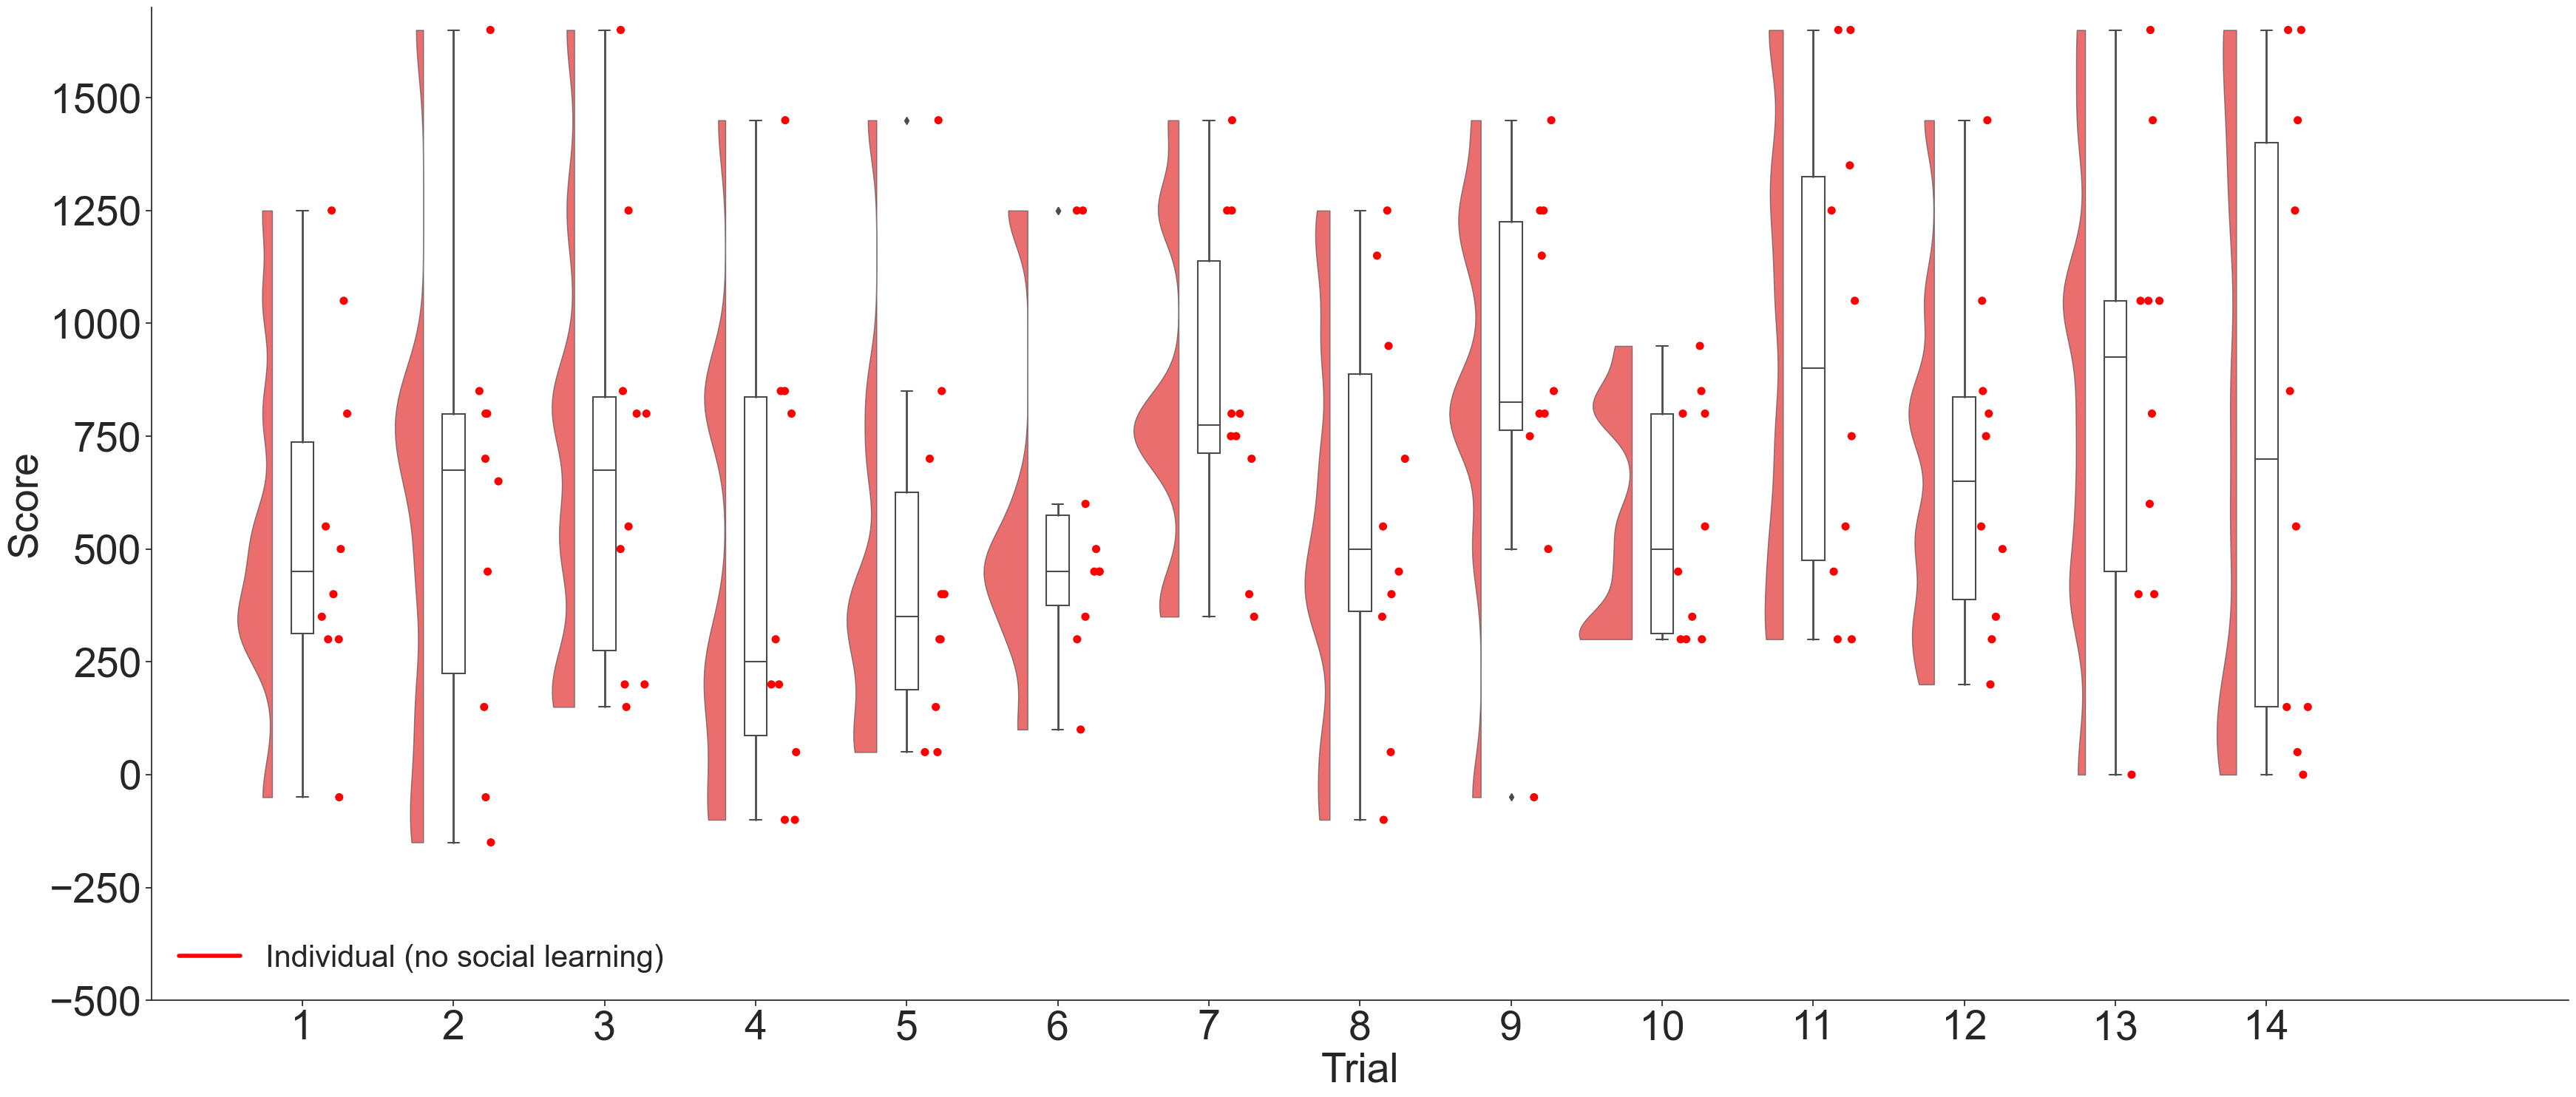

In [11]:
from matplotlib.lines import Line2D


custom_lines = [Line2D([0], [0], color='red', lw=4)]

f, ax = plt.subplots(figsize=(35,15))
pt.RainCloud(x = 'trialIdx',
             y = 'score',
             data = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName'].isin(['rn-iii-pilot-5a']))],
             bw = .2,
             palette=['red'],
             width_viol = .7,
             ax=ax,
             orient = 'v' ,
             alpha = .65,
             dodge = False,
             #pointplot = True,
             move = .2,
             point_size=8)


ax.legend(custom_lines, ['Individual (no social learning)'],loc=3,fontsize=30, frameon=False)

ax.set_xlabel('Trial', fontsize=40)
ax.set_xticklabels(['1','2','3','4','5','6','7','8','9','10','11','12','13','14'], fontsize=40)
ax.set_ylabel('Score', fontsize=40)
plt.yticks(fontsize=40)
ax.set_ylim(-500, 1700)
ax.set_xlim(-1, 15)

plt.tight_layout()
plt.savefig(os.path.join(figures_path,'scores_5A.pdf'), format='pdf', dpi=300)
plt.savefig(os.path.join(figures_path,'scores_5A.png'), format='png', dpi=300)

### 5B

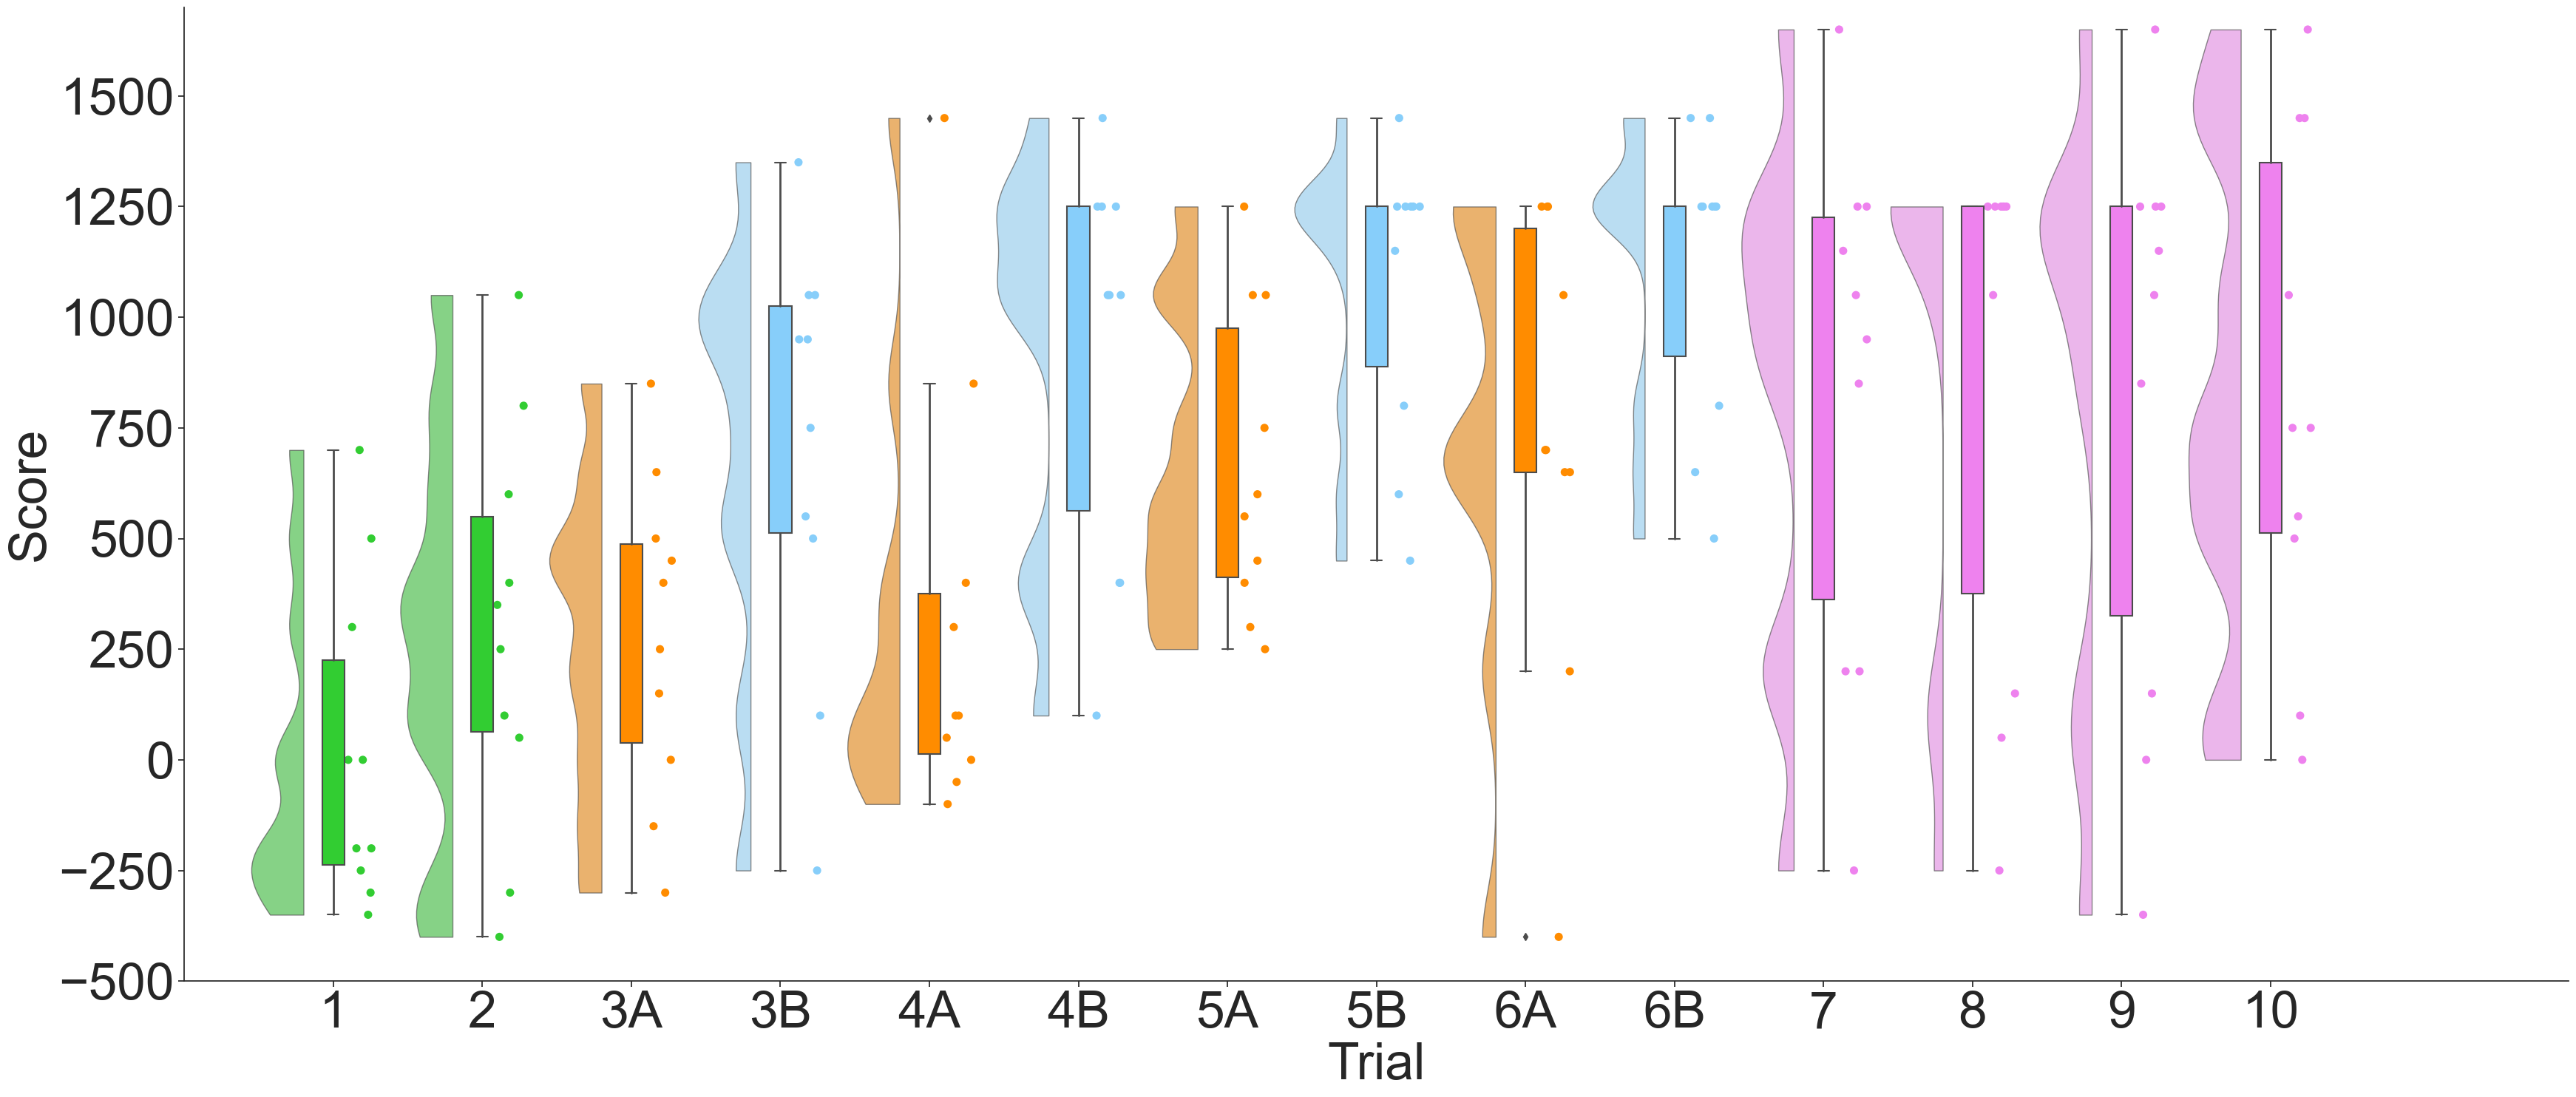

In [17]:
# Raincloud plots
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='limegreen', lw=4),
                Line2D([0], [0], color='darkorange', lw=4),
                Line2D([0], [0], color='lightskyblue', lw=4),
                Line2D([0], [0], color='violet', lw=4)]

f, ax = plt.subplots(figsize=(35,15))
ax = pt.RainCloud(x = 'trialIdx',
             y = 'score',
             hue = 'plot_hue',
             data = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName'].isin(['rn-iii-pilot-5b']))],
             palette = ['darkorange','lightskyblue','limegreen','violet'], # 'Set2
             bw = .2,
             width_viol = .7,
             orient = 'v' ,
             alpha = .65,
             dodge = False,
             # pointplot = True,
             move = .2,
             point_size=8)
# ax.legend(custom_lines, ['Individual (before social learning)',
#                          'Social learning (try yourself)',
#                          'Social learning \n (after advisor demonstration)',
#                          'Individual \n (after social learning)'],loc=2,fontsize=30, frameon=False)

ax.set_xlabel('Trial', fontsize=50)
ax.set_xticklabels(['1','2','3A','3B','4A','4B','5A','5B','6A','6B','7','8','9','10'], fontsize=50)
ax.set_ylabel('Score', fontsize=50)
plt.yticks(fontsize=50)
ax.set_ylim(-500, 1700)
ax.set_xlim(-1, 15)

ax.get_legend().remove()

#g.fig.subplots_adjust(top=0.75)
#g.fig.suptitle("Pilot 5B (with social learning)",  fontsize=17)
plt.tight_layout()
plt.savefig(os.path.join(figures_path,'scores_5B.pdf'), format='pdf', dpi=600)
plt.savefig(os.path.join(figures_path,'scores_5B.png'), format='png', dpi=600)

### 5C

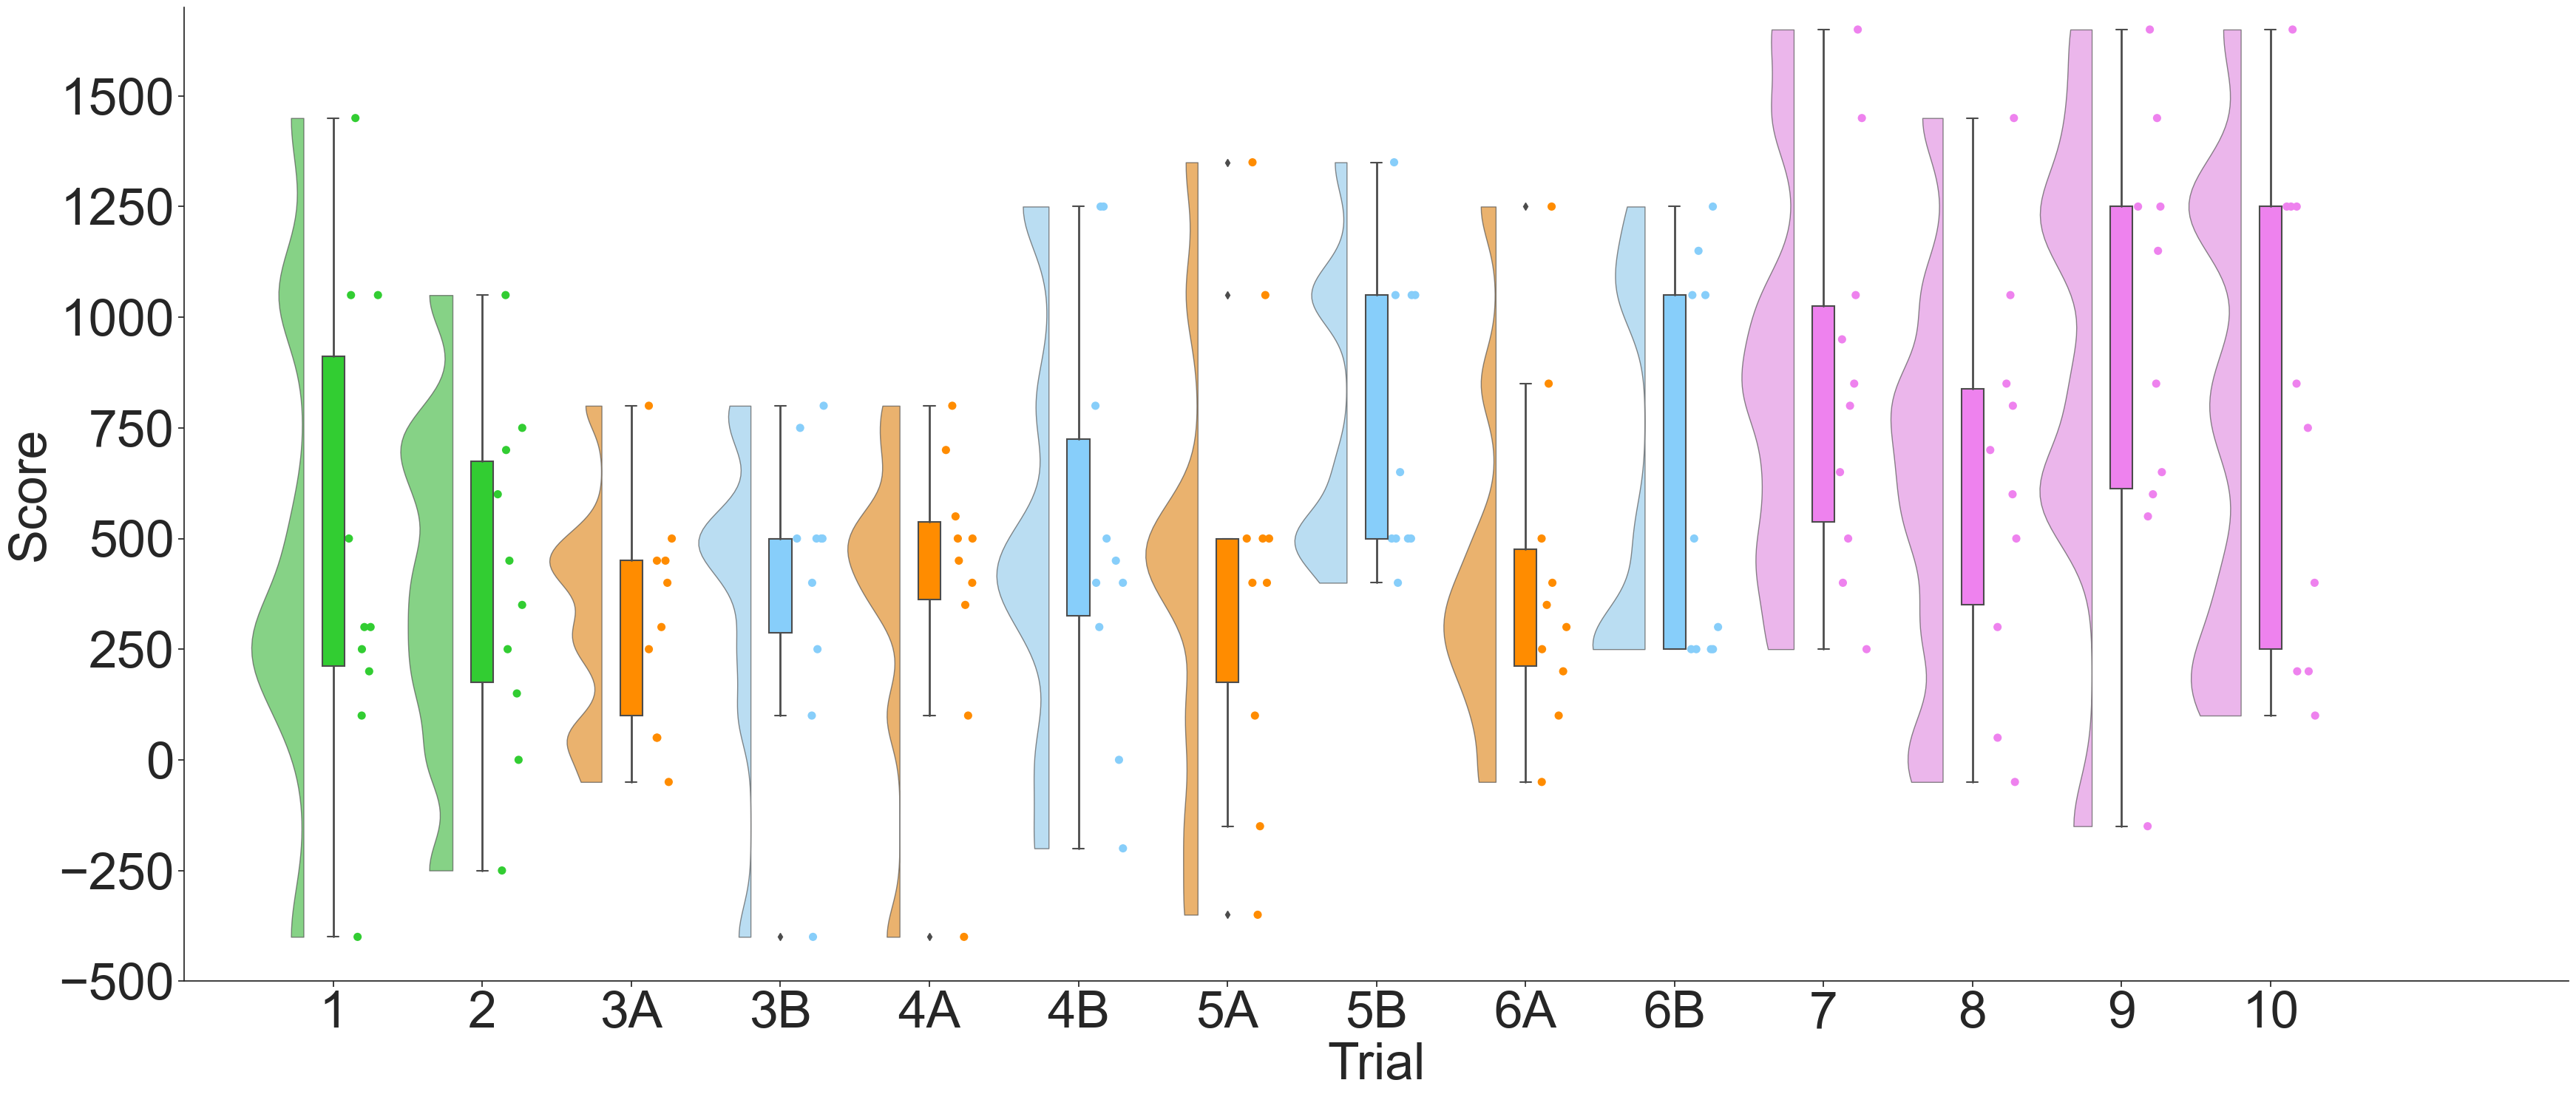

In [18]:
f, ax = plt.subplots(figsize=(35,15))
ax = pt.RainCloud(x = 'trialIdx',
             y = 'score',
             hue = 'plot_hue',
             data = scores_df[(scores_df['isAI']=='Human') & (scores_df['expName'].isin(['rn-iii-pilot-5c']))],
             palette = ['darkorange','lightskyblue','limegreen','violet'], # 'Set2
             bw = .2,
             width_viol = .7,
             orient = 'v' ,
             alpha = .65,
             dodge = False,
             # pointplot = True,
             move = .2,
             point_size=8)
#ax.legend(custom_lines, ['Individual (before social learning)',
#                         'Social learning (try yourself)',
#                         'Social learning \n (after advisor demonstration)',
#                         'Individual \n (after social learning)'],loc=2,fontsize=30, frameon=False)
ax.get_legend().remove()
ax.set_xlabel('Trial', fontsize=50)
ax.set_xticklabels(['1','2','3A','3B','4A','4B','5A','5B','6A','6B','7','8','9','10'], fontsize=50)
ax.set_ylabel('Score', fontsize=50)
plt.yticks(fontsize=50)
ax.set_ylim(-500, 1700)
ax.set_xlim(-1, 15)

#g.fig.subplots_adjust(top=0.75)
#g.fig.suptitle("Pilot 5B (with social learning)",  fontsize=17)
plt.tight_layout()
plt.savefig(os.path.join(figures_path,'scores_5C.pdf'), format='pdf', dpi=600)
plt.savefig(os.path.join(figures_path,'scores_5C.png'), format='png', dpi=600)

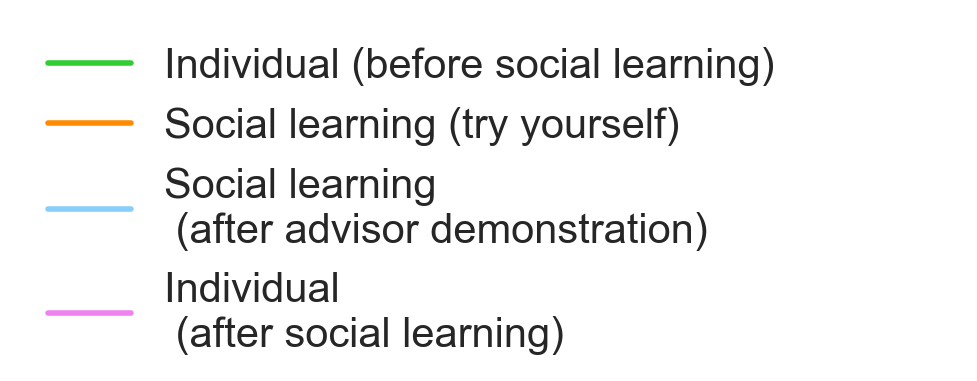

In [23]:
f = plt.figure(figsize=(10,4))
# Create legend
plt.legend(custom_lines, ['Individual (before social learning)',
                        'Social learning (try yourself)',
                        'Social learning \n (after advisor demonstration)',
                        'Individual \n (after social learning)'],loc=2,fontsize=30, frameon=False)
# Get current axes object and turn off axis
plt.gca().set_axis_off()
plt.tight_layout()
plt.savefig(os.path.join(figures_path,'legend.pdf'), format='pdf', dpi=600)
plt.savefig(os.path.join(figures_path,'legend.png'), format='png', dpi=600)